In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS, make_scorer, mean_squared_error
from haversine import haversine
import itertools

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(16,9)
plt.rcParams['axes.grid'] = False

def bic_scorer(estimator, X, y):
    return -1*(len(X) * np.log(mean_squared_error(y, estimator.predict(X))) + 2 * np.sum([i.shape[0] * i.shape[1] for i in mlp.coefs_]))

def import_runs(r) -> pd.DataFrame:
    # List of fields from sheets to drop once we're done with them
    drop_list = ['lat', 'lon', 'prev_lat', 'prev_lon', 'ns1:ele', 'ns1:time', 'ns1:time2']
    
    # Empty DataFrame to append individual run sheets to
    data = pd.DataFrame()
    
    # Switch statement for turning an integer into an iterable
    if type(r) == int:
        iterable = []
        iterable.append(r)
    else:
        iterable = r

    for i in iterable:
        # Iterate through all sheets, perform LAG/LEAD operations, append to main DataFrame

        df = (pd.read_excel(f'Run Sample {i}.xlsx', converters = {'ns1:time': pd.to_datetime, 'ns1:time2': pd.to_datetime})
              [['ns1:time', 'lat', 'lon', 'ns1:ele', 'ns1:time2', 'ns2:hr', 'ns2:cad']]
             )
        df.rename(columns={'ns2:hr':'hr', 'ns2:cad': 'cadence'}, inplace = True)

        # How far deep into the run, in minutes
        # ns1:time is the time that the run started, ns2 is the time of the observation
        df['depth'] = (df['ns1:time2'] - df['ns1:time']).apply(lambda x: x.total_seconds())/60

        # Use shift to replicate LAG() for Haversine law for distance between coordinates
        df[['prev_lat', 'prev_lon']] = df[['lat', 'lon']].shift()
        df['speed'] = ((df.apply(lambda x: haversine((x['prev_lat'], x['prev_lon']), (x['lat'], x['lon'])), axis = 1))*60)

        # Get change in speed (km/min)
        df['speed_gain'] = (df['speed'] - df['speed'].shift())

        # Get change in altitude
        df['elev_gain'] = df['ns1:ele'] - df['ns1:ele'].shift()

        df['prev_hr'] = df['hr'].shift()

        cadence_change = (df['cadence'] - df['cadence'].shift()).copy().dropna()

        df.drop(columns = drop_list, inplace = True)
        data = data.append(df)

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace = True)
    
    return data

### Importing Train/Test Data

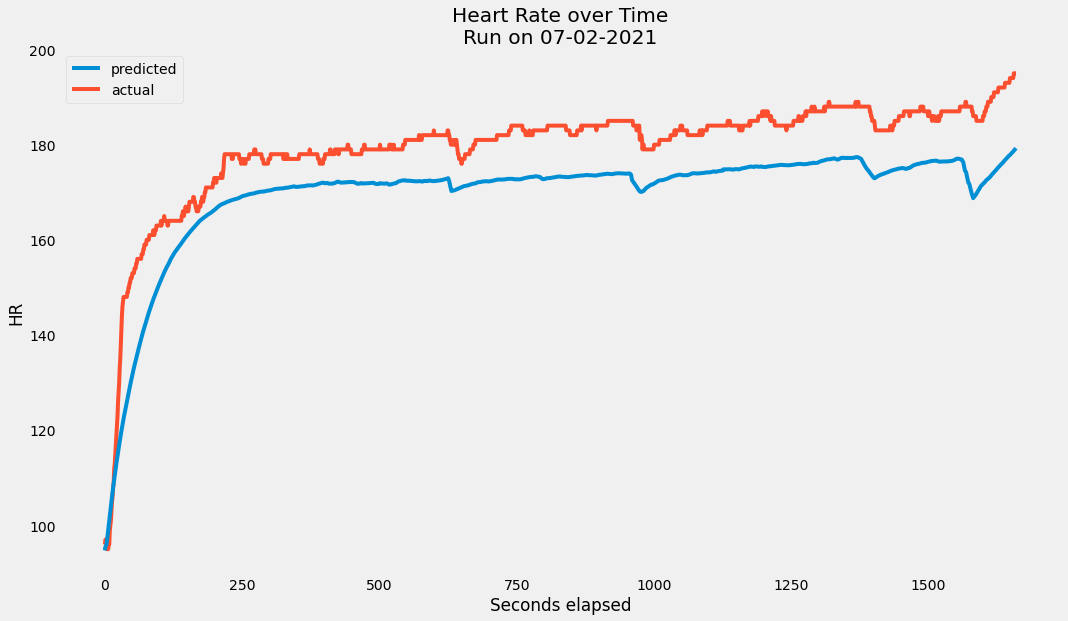

In [3]:
data=import_runs(range(1,27))
X = data.drop(columns='hr').copy()

# Import test data
test = import_runs(27)

mlp = MLPRegressor(max_iter = 2000, hidden_layer_sizes = (7,)).fit(X, data['hr'])

hr = 94
hr_list = []
for i in range(len(test)):
    hr = mlp.predict(np.append(test.iloc[i,1:X.shape[1]], hr).reshape(1,-1))
    hr_list.append(hr[0])
    
plt.plot(hr_list, label = 'predicted', zorder = 2)
plt.plot(test['hr'], label = 'actual', zorder = 1)
plt.legend()

plt.title('Heart Rate over Time\nRun on 07-02-2021')
plt.xlabel('Seconds elapsed')
plt.ylabel('HR');

### NN hyperparameter tuning using GridSearchCV

In [ ]:
%%time
# Use itertools to create different number of hidden layers and hidden layer sizes
it = list(itertools.combinations([7, 8, 9, 10], 1))
# it.extend(list(itertools.combinations([7, 8, 9, 10], 2)))
# it.extend(list(itertools.combinations([7, 8, 9, 10], 3)))

# Create and fit GridSearchCV object
parameters = {'hidden_layer_sizes': it, 'activation': ['relu', 'identity', 'logistic', 'tanh']}
mlp_grid = GridSearchCV(MLPRegressor(max_iter = 2000), parameters, scoring = bic_scorer, cv = 10)
mlp_grid.fit(X, data['hr'])

# Pick best model and fit using training subset
best_mlp = mlp_grid.best_estimator_
best_mlp.fit(X, data['hr'])

best_mlp